In [1]:
#!/usr/bin/env python3

import os, sys
sys.path.append('../')
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

from triggers_helper import CalRatioHighET_L1,CalRatioLowET_L1,CalRatio_HLT
import sys
sys.path.append('../')

try:
    import mplhep as hep
    hep.style.use("ATLAS")
except:
    pass
delphesDir = os.path.abspath("../DelphesLLP")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')



Welcome to JupyROOT 6.30/06


True

## Read events

In [2]:
inputFile = '../ddmH_mS_500_m1_244_dm_90_nosmear.root'
# inputFile = '../DelphesLLP/test.root'

### Get LLP decay position and time from truth level events (does not include propagation)

In [3]:
f = ROOT.TFile(inputFile,'read')
tree = f.Get("Delphes")

c_light = 2.99792458e8

nevts = tree.GetEntries()
rDecays = []
triggerFlags = []
for ievt in range(nevts):
    tree.GetEntry(ievt)
    event = {
            'jetsL1' : tree.L1SmallJetOnTime, 
            'jetsHLT' : tree.HLTJetOnTime,
            'tracks' : []
            }  

    l1_cutflow = CalRatioLowET_L1(event['jetsL1'])
    # If failed, check high ET trigger
    if any(val == 0 for val in l1_cutflow.values()):
        l1_cutflow = CalRatioHighET_L1(event['jetsL1'],pTmin = 60.0)
    l1_pass = all(val != 0 for val in l1_cutflow.values())
    hlt_cutflow = CalRatio_HLT(event['jetsHLT'],event['tracks'])
    hlt_pass = all(val != 0 for val in hlt_cutflow.values())
    triggerFlags.append((l1_pass,hlt_pass))

    # Get parton level MET and b-bar angular separation
    llps = list(tree.llpParticles)
    llpDec = {}
    for d in tree.llpDirectDaughters:
        illp = d.M1
        x = np.array([d.X,d.Y,d.Z,d.T])
        l = np.linalg.norm(x[:3])*1e-3
        t_readout = x[-1]-l/c_light
        # # Select only decays on the N-1 event
        # if t_readout > 10e-9:
        #     continue
        x[-1] = t_readout
        llpDec[illp] = x
    decs = sorted(llpDec.values(), key = lambda d : d[-1])
    rDecays.append(decs)
f.Close()

In [4]:
rDecays = np.array(rDecays)
triggerFlags = np.array(triggerFlags)

### Check L1 and HLT acceptances

In [6]:
passL1 = len(triggerFlags[triggerFlags[:,0] > 0])
passL1HLT = len(triggerFlags[triggerFlags[:,0]*triggerFlags[:,1] > 0])
print(f'Total Number of events = {len(triggerFlags)}')
print(f'Events passing L1 = {passL1}')
print(f'Events passing L1+HLT = {passL1HLT}')

Total Number of events = 38862
Events passing L1 = 12591
Events passing L1+HLT = 2770


### Select events passing triggers

In [7]:
rDecaysL1 = rDecays[triggerFlags[:,0] > 0]
rDecaysL1HLT = rDecays[triggerFlags[:,0]*triggerFlags[:,1] > 0]

### Compute decay position for all LLPs from events passing L1+HLT

In [8]:
pts = []
for d in rDecaysL1HLT:
    for dec in d:
        r = np.linalg.norm(dec[:2])*1e-3
        z = dec[2]*1e-3
        pts.append([r,z,dec[-1]])

pts = np.array(pts)

### Select only the LLPs with readout time under 10 ns

In [9]:
pts_ontime = pts[pts[:,-1] < 10e-9]

### Plot decays

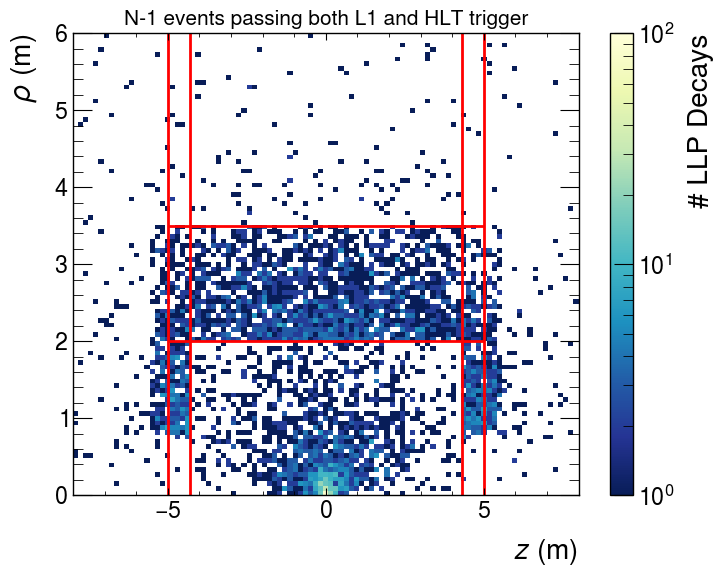

In [19]:
plt.hist2d(pts_ontime[:,1],pts_ontime[:,0],
           bins=[np.linspace(-8,8,100),np.linspace(0.,6.,100)],
           cmap = mpl.colormaps['YlGnBu_r'], norm = mpl.colors.LogNorm(vmin=1.0,vmax=100.))
plt.vlines(x=[4.3,5.0],ymin=0.,ymax=10.,colors='red')
plt.vlines(x=[-4.3,-5.0],ymin=0.,ymax=10.,colors='red')
plt.hlines(y=[2.0,3.5],xmin=-5.0,xmax=5.0,colors='red')
plt.colorbar(label='# LLP Decays')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\rho$ (m)')
plt.title('N-1 events passing both L1 and HLT trigger',fontsize=15)
plt.show()

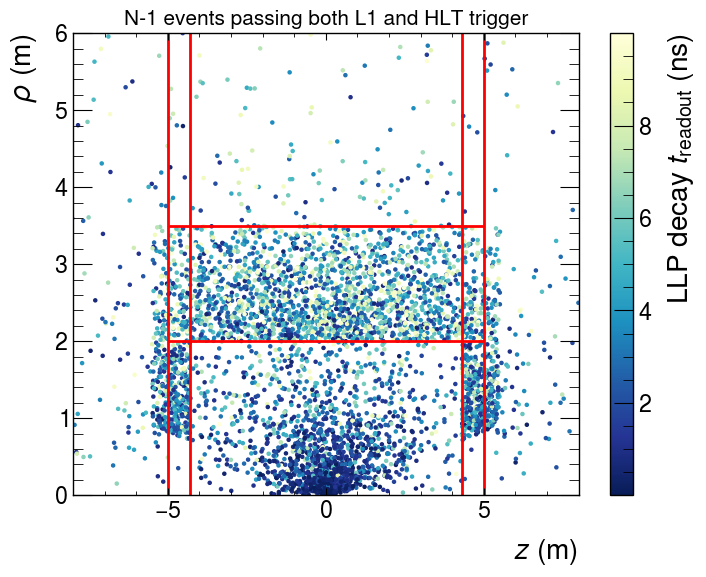

In [21]:
plt.scatter(pts_ontime[:,1],pts_ontime[:,0],c=(1e9*pts_ontime[:,-1]),
           cmap = mpl.colormaps['YlGnBu_r'],s=5)
plt.vlines(x=[4.3,5.0],ymin=0.,ymax=10.,colors='red')
plt.vlines(x=[-4.3,-5.0],ymin=0.,ymax=10.,colors='red')
plt.hlines(y=[2.0,3.5],xmin=-5.0,xmax=5.0,colors='red')
plt.colorbar(label=r'LLP decay $t_{\rm readout}$ (ns)')
plt.xlim(-8,8)
plt.ylim(0.,6)
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\rho$ (m)')
plt.title('N-1 events passing both L1 and HLT trigger',fontsize=15)
plt.show()